In [2]:
########################################################################################
# Davi Frossard, 2016                                                                  #
# VGG16 implementation in TensorFlow                                                   #
# Details:                                                                             #
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      #
#                                                                                      #
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################
import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
import os



def consin(p=[],q=[]):

    # 获取 p、q 数组的维度信息
    shape_n = len(p)

    # 求出p，q的乘积和
    sum_xy = sum([p[i]*q[i] for i in range(shape_n)])
    # 分别求出p，q的平方和
    sum_x_sq = sum([p[i]**2 for i in range(shape_n)])
    sum_y_sq = sum([q[i]**2 for i in range(shape_n)])
    # 求出consin相关系数
    up = sum_xy
    down = (sum_x_sq*sum_y_sq)**.5
    # 若down为零则不能计算，return 0
    if down == 0 :return 0

    result = up/down
    return result





class vgg16:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

    def fc_layers(self):
        # fc1
        with tf.name_scope('fc1') as scope:
            shape = int(np.prod(self.pool5.get_shape()[1:]))
            fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            pool5_flat = tf.reshape(self.pool5, [-1, shape])
            fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
            self.fc1 = tf.nn.relu(fc1l)
            self.parameters += [fc1w, fc1b]

        # fc2
        with tf.name_scope('fc2') as scope:
            fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                                 trainable=True, name='biases')
            fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
            self.fc2 = tf.nn.relu(fc2l)
            self.parameters += [fc2w, fc2b]

        # fc3
        with tf.name_scope('fc3') as scope:
            fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
                                                         dtype=tf.float32,
                                                         stddev=1e-1), name='weights')
            fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
                                 trainable=True, name='biases')
            self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
            self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print (i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))

if __name__ == '__main__':
    sess = tf.Session()
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16(imgs, 'vgg16_weights.npz', sess)

    # img1 = imread('3.jpg', mode='RGB')
    # img1 = imresize(img1, (224, 224))
    #
    # img2 = imread('6.jpg', mode='RGB')
    # img2 = imresize(img2, (224, 224))
    #
    # img7 = imread('7.jpg', mode='RGB')
    # img7 = imresize(img7, (224, 224))
    #
    # img8 = imread('8.jpg', mode='RGB')
    # img8 = imresize(img8, (224, 224))
    #
    # # prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
    # # conv5_3 = sess.run(vgg.conv5_3, feed_dict={vgg.imgs: [img1]})[0]
    # # pool5_value = sess.run(vgg.pool5, feed_dict={vgg.imgs: [img1]})[0]
    #
    # ##########################
    # fc1_value1 = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img1]})[0]
    # fc1_value2 = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img2]})[0]
    #
    # fc1_value7 = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img7]})[0]
    # fc1_value8 = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img8]})[0]
    #
    # udis1_2 = np.sqrt(np.sum(np.square(fc1_value1 - fc1_value2)))
    # udis2_3 = np.sqrt(np.sum(np.square(fc1_value2 - fc1_value7)))
    # udis7_8 = np.sqrt(np.sum(np.square(fc1_value7 - fc1_value8)))

    num_image_zhang = 0
    list_u_dis = []
    list_consin_result = []
    for i in range(len(os.listdir('./ImageData/counterexample/')) - 1):
        num_image_zhang = num_image_zhang + 1
        img_raw = imread('ImageData/counterexample/' +'counterexample'+ str(num_image_zhang) + '.jpg', mode='RGB')
        img_size224 = imresize(img_raw, (224, 224))
        print("./all_images/" + str(num_image_zhang) + ".jpg")

        fc1_value_now = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img_size224]})[0]
        if num_image_zhang != 1:
            img_raw_last =  imread(r"ImageData/counterexample/" +"counterexample"+ str(num_image_zhang -1 ) + ".jpg", mode='RGB')
            img_size224_last = imresize(img_raw_last, (224, 224))
            fc1_value_last = sess.run(vgg.fc1, feed_dict={vgg.imgs: [img_size224_last]})[0]

            # 计算欧式距离
            u_dis = np.sqrt(np.sum(np.square(fc1_value_now - fc1_value_last)))
            consin_result = consin(fc1_value_now,fc1_value_last)
            list_u_dis.append(u_dis)
            list_consin_result.append(consin_result)
            print( "当前照片是 ",str(num_image_zhang) + ".jpg","与照片",str(num_image_zhang - 1) + ".jpg    ","欧式距离：   ",u_dis,"      相似度：  ",consin_result)





    # print()
    ###################################
    # preds = (np.argsort(prob)[::-1])[0:5]
    # for p in preds:
    #     print (class_names[p], prob[p])


0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)
./all_images/1.jpg


/root/anaconda3/envs/tensorflow-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:315: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/root/anaconda3/envs/tensorflow-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:316: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


./all_images/2.jpg


/root/anaconda3/envs/tensorflow-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:321: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/root/anaconda3/envs/tensorflow-3.5/lib/python3.5/site-packages/ipykernel_launcher.py:322: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


当前照片是  2.jpg 与照片 1.jpg     欧式距离：    258.5859       相似度：   0.3242134830338613
./all_images/3.jpg
当前照片是  3.jpg 与照片 2.jpg     欧式距离：    215.13072       相似度：   0.31912304369410527
./all_images/4.jpg
当前照片是  4.jpg 与照片 3.jpg     欧式距离：    186.28024       相似度：   0.5841887453415355
./all_images/5.jpg
当前照片是  5.jpg 与照片 4.jpg     欧式距离：    251.59875       相似度：   0.3213010867412955
./all_images/6.jpg
当前照片是  6.jpg 与照片 5.jpg     欧式距离：    232.20546       相似度：   0.4920467973160581
./all_images/7.jpg
当前照片是  7.jpg 与照片 6.jpg     欧式距离：    242.32968       相似度：   0.4880098888070315
./all_images/8.jpg
当前照片是  8.jpg 与照片 7.jpg     欧式距离：    263.0369       相似度：   0.44648218015640245
./all_images/9.jpg
当前照片是  9.jpg 与照片 8.jpg     欧式距离：    229.5691       相似度：   0.40894989442513574
./all_images/10.jpg
当前照片是  10.jpg 与照片 9.jpg     欧式距离：    196.68115       相似度：   0.4185001293434312
./all_images/11.jpg
当前照片是  11.jpg 与照片 10.jpg     欧式距离：    200.79414       相似度：   0.47917947123349536
./all_images/12.jpg
当前照片是  12.jpg 与照片 11.jp

当前照片是  85.jpg 与照片 84.jpg     欧式距离：    219.78621       相似度：   0.5637744492280027
./all_images/86.jpg
当前照片是  86.jpg 与照片 85.jpg     欧式距离：    280.35114       相似度：   0.4795217987987319
./all_images/87.jpg
当前照片是  87.jpg 与照片 86.jpg     欧式距离：    347.1864       相似度：   0.37060604614559933
./all_images/88.jpg
当前照片是  88.jpg 与照片 87.jpg     欧式距离：    297.84058       相似度：   0.41462800790565996
./all_images/89.jpg
当前照片是  89.jpg 与照片 88.jpg     欧式距离：    220.46516       相似度：   0.34347537459242977
./all_images/90.jpg
当前照片是  90.jpg 与照片 89.jpg     欧式距离：    227.68114       相似度：   0.33346996762069087
./all_images/91.jpg
当前照片是  91.jpg 与照片 90.jpg     欧式距离：    257.71243       相似度：   0.2047016596768557
./all_images/92.jpg
当前照片是  92.jpg 与照片 91.jpg     欧式距离：    283.72278       相似度：   0.19303210391530537
./all_images/93.jpg
当前照片是  93.jpg 与照片 92.jpg     欧式距离：    289.79037       相似度：   0.3341637357579029
./all_images/94.jpg
当前照片是  94.jpg 与照片 93.jpg     欧式距离：    252.37947       相似度：   0.4255176763967585
./all_images/95.

当前照片是  165.jpg 与照片 164.jpg     欧式距离：    278.71442       相似度：   0.3676225095403585
./all_images/166.jpg
当前照片是  166.jpg 与照片 165.jpg     欧式距离：    184.51443       相似度：   0.40737149158026786
./all_images/167.jpg
当前照片是  167.jpg 与照片 166.jpg     欧式距离：    186.10957       相似度：   0.4086425959079871
./all_images/168.jpg
当前照片是  168.jpg 与照片 167.jpg     欧式距离：    215.12598       相似度：   0.3490424969490701
./all_images/169.jpg
当前照片是  169.jpg 与照片 168.jpg     欧式距离：    260.68466       相似度：   0.2468400484358599
./all_images/170.jpg
当前照片是  170.jpg 与照片 169.jpg     欧式距离：    257.0204       相似度：   0.24499162365448773
./all_images/171.jpg
当前照片是  171.jpg 与照片 170.jpg     欧式距离：    261.92584       相似度：   0.3649808696840617
./all_images/172.jpg
当前照片是  172.jpg 与照片 171.jpg     欧式距离：    256.65262       相似度：   0.4476536834309448
./all_images/173.jpg
当前照片是  173.jpg 与照片 172.jpg     欧式距离：    218.26587       相似度：   0.4305836258200247
./all_images/174.jpg
当前照片是  174.jpg 与照片 173.jpg     欧式距离：    227.66959       相似度：   0.4947389

当前照片是  245.jpg 与照片 244.jpg     欧式距离：    196.14642       相似度：   0.3595305672947169
./all_images/246.jpg
当前照片是  246.jpg 与照片 245.jpg     欧式距离：    216.8338       相似度：   0.28961342041748994
./all_images/247.jpg
当前照片是  247.jpg 与照片 246.jpg     欧式距离：    223.37321       相似度：   0.18706711782602667
./all_images/248.jpg
当前照片是  248.jpg 与照片 247.jpg     欧式距离：    224.40025       相似度：   0.2786812849860132
./all_images/249.jpg
当前照片是  249.jpg 与照片 248.jpg     欧式距离：    240.88644       相似度：   0.2978126144015174
./all_images/250.jpg
当前照片是  250.jpg 与照片 249.jpg     欧式距离：    287.04575       相似度：   0.33730798150143904
./all_images/251.jpg
当前照片是  251.jpg 与照片 250.jpg     欧式距离：    261.0475       相似度：   0.4268830267004417
./all_images/252.jpg
当前照片是  252.jpg 与照片 251.jpg     欧式距离：    224.45357       相似度：   0.5035904127385087
./all_images/253.jpg
当前照片是  253.jpg 与照片 252.jpg     欧式距离：    261.9306       相似度：   0.25689065850139553
./all_images/254.jpg
当前照片是  254.jpg 与照片 253.jpg     欧式距离：    225.1134       相似度：   0.30579749

当前照片是  325.jpg 与照片 324.jpg     欧式距离：    274.94046       相似度：   0.16634745558033046
./all_images/326.jpg
当前照片是  326.jpg 与照片 325.jpg     欧式距离：    262.7066       相似度：   0.22386859591666394
./all_images/327.jpg
当前照片是  327.jpg 与照片 326.jpg     欧式距离：    240.9047       相似度：   0.3022944793399934
./all_images/328.jpg
当前照片是  328.jpg 与照片 327.jpg     欧式距离：    222.16112       相似度：   0.29389398809211753
./all_images/329.jpg
当前照片是  329.jpg 与照片 328.jpg     欧式距离：    207.2575       相似度：   0.4310316662501783
./all_images/330.jpg
当前照片是  330.jpg 与照片 329.jpg     欧式距离：    214.68733       相似度：   0.5778876773947529
./all_images/331.jpg
当前照片是  331.jpg 与照片 330.jpg     欧式距离：    289.60873       相似度：   0.2543083678409
./all_images/332.jpg
当前照片是  332.jpg 与照片 331.jpg     欧式距离：    292.13165       相似度：   0.20818311625380279
./all_images/333.jpg
当前照片是  333.jpg 与照片 332.jpg     欧式距离：    243.49307       相似度：   0.4353551007898955
./all_images/334.jpg
当前照片是  334.jpg 与照片 333.jpg     欧式距离：    273.98746       相似度：   0.3068568192

当前照片是  405.jpg 与照片 404.jpg     欧式距离：    236.65262       相似度：   0.35507037675145664
./all_images/406.jpg
当前照片是  406.jpg 与照片 405.jpg     欧式距离：    280.7504       相似度：   0.376993870944088
./all_images/407.jpg
当前照片是  407.jpg 与照片 406.jpg     欧式距离：    282.81442       相似度：   0.3500329559471354
./all_images/408.jpg
当前照片是  408.jpg 与照片 407.jpg     欧式距离：    270.3438       相似度：   0.3678669727397529
./all_images/409.jpg
当前照片是  409.jpg 与照片 408.jpg     欧式距离：    309.21738       相似度：   0.24051945129159355
./all_images/410.jpg
当前照片是  410.jpg 与照片 409.jpg     欧式距离：    252.78134       相似度：   0.27817447016770447
./all_images/411.jpg
当前照片是  411.jpg 与照片 410.jpg     欧式距离：    355.24243       相似度：   0.28195068813646607
./all_images/412.jpg
当前照片是  412.jpg 与照片 411.jpg     欧式距离：    369.7786       相似度：   0.2653670460360578
./all_images/413.jpg
当前照片是  413.jpg 与照片 412.jpg     欧式距离：    208.90886       相似度：   0.48131840380554197
./all_images/414.jpg
当前照片是  414.jpg 与照片 413.jpg     欧式距离：    254.14445       相似度：   0.3551985

当前照片是  485.jpg 与照片 484.jpg     欧式距离：    296.5463       相似度：   0.32805516493111014
./all_images/486.jpg
当前照片是  486.jpg 与照片 485.jpg     欧式距离：    228.97823       相似度：   0.5461354497110397
./all_images/487.jpg
当前照片是  487.jpg 与照片 486.jpg     欧式距离：    270.6604       相似度：   0.21222693061542813
./all_images/488.jpg
当前照片是  488.jpg 与照片 487.jpg     欧式距离：    205.30653       相似度：   0.28619070510344974
./all_images/489.jpg
当前照片是  489.jpg 与照片 488.jpg     欧式距离：    207.3994       相似度：   0.34154745965967204
./all_images/490.jpg
当前照片是  490.jpg 与照片 489.jpg     欧式距离：    251.06746       相似度：   0.28083851091294876
./all_images/491.jpg
当前照片是  491.jpg 与照片 490.jpg     欧式距离：    199.869       相似度：   0.5409626098338067
./all_images/492.jpg
当前照片是  492.jpg 与照片 491.jpg     欧式距离：    243.70183       相似度：   0.4006995496480666
./all_images/493.jpg
当前照片是  493.jpg 与照片 492.jpg     欧式距离：    222.50978       相似度：   0.5383003837117781
./all_images/494.jpg
当前照片是  494.jpg 与照片 493.jpg     欧式距离：    261.84723       相似度：   0.18453034

当前照片是  565.jpg 与照片 564.jpg     欧式距离：    193.94637       相似度：   0.28855317956826265
./all_images/566.jpg
当前照片是  566.jpg 与照片 565.jpg     欧式距离：    212.80058       相似度：   0.43039368124796973
./all_images/567.jpg
当前照片是  567.jpg 与照片 566.jpg     欧式距离：    235.95573       相似度：   0.364956577371037
./all_images/568.jpg
当前照片是  568.jpg 与照片 567.jpg     欧式距离：    198.86414       相似度：   0.4946292480358646
./all_images/569.jpg
当前照片是  569.jpg 与照片 568.jpg     欧式距离：    216.27348       相似度：   0.4209050307690754
./all_images/570.jpg
当前照片是  570.jpg 与照片 569.jpg     欧式距离：    183.11647       相似度：   0.5682030200881085
./all_images/571.jpg
当前照片是  571.jpg 与照片 570.jpg     欧式距离：    256.6602       相似度：   0.187646985828017
./all_images/572.jpg
当前照片是  572.jpg 与照片 571.jpg     欧式距离：    280.25064       相似度：   0.2115988289099501
./all_images/573.jpg
当前照片是  573.jpg 与照片 572.jpg     欧式距离：    265.9235       相似度：   0.3394913600118899
./all_images/574.jpg
当前照片是  574.jpg 与照片 573.jpg     欧式距离：    247.90115       相似度：   0.1666237946

当前照片是  645.jpg 与照片 644.jpg     欧式距离：    302.45673       相似度：   0.1873168911252576
./all_images/646.jpg
当前照片是  646.jpg 与照片 645.jpg     欧式距离：    244.49876       相似度：   0.16189514840856772
./all_images/647.jpg
当前照片是  647.jpg 与照片 646.jpg     欧式距离：    224.71797       相似度：   0.32633760371955917
./all_images/648.jpg
当前照片是  648.jpg 与照片 647.jpg     欧式距离：    222.48285       相似度：   0.4482929133700546
./all_images/649.jpg
当前照片是  649.jpg 与照片 648.jpg     欧式距离：    233.98534       相似度：   0.33651673297502505
./all_images/650.jpg
当前照片是  650.jpg 与照片 649.jpg     欧式距离：    215.37973       相似度：   0.38549827901438094
./all_images/651.jpg
当前照片是  651.jpg 与照片 650.jpg     欧式距离：    213.47841       相似度：   0.2671827514429041
./all_images/652.jpg
当前照片是  652.jpg 与照片 651.jpg     欧式距离：    236.7548       相似度：   0.33496560165395506
./all_images/653.jpg
当前照片是  653.jpg 与照片 652.jpg     欧式距离：    234.01897       相似度：   0.46211677281283176
./all_images/654.jpg
当前照片是  654.jpg 与照片 653.jpg     欧式距离：    224.2333       相似度：   0.2841

当前照片是  725.jpg 与照片 724.jpg     欧式距离：    208.63063       相似度：   0.5937013186416967
./all_images/726.jpg
当前照片是  726.jpg 与照片 725.jpg     欧式距离：    198.05258       相似度：   0.765619037043387
./all_images/727.jpg
当前照片是  727.jpg 与照片 726.jpg     欧式距离：    311.273       相似度：   0.2815012623941416
./all_images/728.jpg
当前照片是  728.jpg 与照片 727.jpg     欧式距离：    231.54398       相似度：   0.2336704465157248
./all_images/729.jpg
当前照片是  729.jpg 与照片 728.jpg     欧式距离：    202.39021       相似度：   0.3482014916852538
./all_images/730.jpg
当前照片是  730.jpg 与照片 729.jpg     欧式距离：    179.74792       相似度：   0.4103273184239187
./all_images/731.jpg
当前照片是  731.jpg 与照片 730.jpg     欧式距离：    245.04538       相似度：   0.2579169672315606
./all_images/732.jpg
当前照片是  732.jpg 与照片 731.jpg     欧式距离：    269.28564       相似度：   0.33126410876980994
./all_images/733.jpg
当前照片是  733.jpg 与照片 732.jpg     欧式距离：    248.41893       相似度：   0.49895900316779535
./all_images/734.jpg
当前照片是  734.jpg 与照片 733.jpg     欧式距离：    219.626       相似度：   0.54228866677

当前照片是  805.jpg 与照片 804.jpg     欧式距离：    211.84286       相似度：   0.5251174911559525
./all_images/806.jpg
当前照片是  806.jpg 与照片 805.jpg     欧式距离：    212.82858       相似度：   0.47503691069474263
./all_images/807.jpg
当前照片是  807.jpg 与照片 806.jpg     欧式距离：    207.72974       相似度：   0.4263003521836681
./all_images/808.jpg
当前照片是  808.jpg 与照片 807.jpg     欧式距离：    216.33324       相似度：   0.45760649001486703
./all_images/809.jpg
当前照片是  809.jpg 与照片 808.jpg     欧式距离：    239.9995       相似度：   0.5682293335963352
./all_images/810.jpg
当前照片是  810.jpg 与照片 809.jpg     欧式距离：    266.58444       相似度：   0.4122317332268407
./all_images/811.jpg
当前照片是  811.jpg 与照片 810.jpg     欧式距离：    180.75008       相似度：   0.4832662424433275
./all_images/812.jpg
当前照片是  812.jpg 与照片 811.jpg     欧式距离：    227.82915       相似度：   0.30970779514852886
./all_images/813.jpg
当前照片是  813.jpg 与照片 812.jpg     欧式距离：    288.6194       相似度：   0.24247014139227527
./all_images/814.jpg
当前照片是  814.jpg 与照片 813.jpg     欧式距离：    285.57477       相似度：   0.267271

当前照片是  885.jpg 与照片 884.jpg     欧式距离：    259.96384       相似度：   0.41257927322170246
./all_images/886.jpg
当前照片是  886.jpg 与照片 885.jpg     欧式距离：    275.06866       相似度：   0.2435627976423841
./all_images/887.jpg
当前照片是  887.jpg 与照片 886.jpg     欧式距离：    253.91475       相似度：   0.2907261797964203
./all_images/888.jpg
当前照片是  888.jpg 与照片 887.jpg     欧式距离：    239.28963       相似度：   0.341169081255147
./all_images/889.jpg
当前照片是  889.jpg 与照片 888.jpg     欧式距离：    248.36449       相似度：   0.1800445508670138
./all_images/890.jpg
当前照片是  890.jpg 与照片 889.jpg     欧式距离：    254.02562       相似度：   0.20918261776035837
./all_images/891.jpg
当前照片是  891.jpg 与照片 890.jpg     欧式距离：    235.71786       相似度：   0.39313638015589336
./all_images/892.jpg
当前照片是  892.jpg 与照片 891.jpg     欧式距离：    219.932       相似度：   0.3814936761967411
./all_images/893.jpg
当前照片是  893.jpg 与照片 892.jpg     欧式距离：    231.58464       相似度：   0.47433925202484095
./all_images/894.jpg
当前照片是  894.jpg 与照片 893.jpg     欧式距离：    227.12448       相似度：   0.5165752

当前照片是  965.jpg 与照片 964.jpg     欧式距离：    220.00893       相似度：   0.44871687334330446
./all_images/966.jpg
当前照片是  966.jpg 与照片 965.jpg     欧式距离：    241.2342       相似度：   0.2835025063329519
./all_images/967.jpg
当前照片是  967.jpg 与照片 966.jpg     欧式距离：    260.31058       相似度：   0.2970844774764563
./all_images/968.jpg
当前照片是  968.jpg 与照片 967.jpg     欧式距离：    206.24533       相似度：   0.5658458358235838
./all_images/969.jpg
当前照片是  969.jpg 与照片 968.jpg     欧式距离：    206.88077       相似度：   0.45053117135098725
./all_images/970.jpg
当前照片是  970.jpg 与照片 969.jpg     欧式距离：    213.228       相似度：   0.5438613644412335
./all_images/971.jpg
当前照片是  971.jpg 与照片 970.jpg     欧式距离：    217.2564       相似度：   0.5005601941271953
./all_images/972.jpg
当前照片是  972.jpg 与照片 971.jpg     欧式距离：    255.54897       相似度：   0.3395717795360082
./all_images/973.jpg
当前照片是  973.jpg 与照片 972.jpg     欧式距离：    237.22583       相似度：   0.5126709905584246
./all_images/974.jpg
当前照片是  974.jpg 与照片 973.jpg     欧式距离：    218.21921       相似度：   0.5858217458

当前照片是  1044.jpg 与照片 1043.jpg     欧式距离：    210.47388       相似度：   0.41787316355575727
./all_images/1045.jpg
当前照片是  1045.jpg 与照片 1044.jpg     欧式距离：    183.31505       相似度：   0.6357193782237613
./all_images/1046.jpg
当前照片是  1046.jpg 与照片 1045.jpg     欧式距离：    231.17378       相似度：   0.3928468948218075
./all_images/1047.jpg
当前照片是  1047.jpg 与照片 1046.jpg     欧式距离：    235.97054       相似度：   0.15871440094204387
./all_images/1048.jpg
当前照片是  1048.jpg 与照片 1047.jpg     欧式距离：    284.33255       相似度：   0.17251608538910113
./all_images/1049.jpg
当前照片是  1049.jpg 与照片 1048.jpg     欧式距离：    260.4006       相似度：   0.3038848465314073
./all_images/1050.jpg
当前照片是  1050.jpg 与照片 1049.jpg     欧式距离：    212.74463       相似度：   0.26207518136279506
./all_images/1051.jpg
当前照片是  1051.jpg 与照片 1050.jpg     欧式距离：    234.28935       相似度：   0.2537845749803746
./all_images/1052.jpg
当前照片是  1052.jpg 与照片 1051.jpg     欧式距离：    248.98021       相似度：   0.40949535644399926
./all_images/1053.jpg
当前照片是  1053.jpg 与照片 1052.jpg     欧式距离：    

当前照片是  1122.jpg 与照片 1121.jpg     欧式距离：    195.67574       相似度：   0.33014273718612724
./all_images/1123.jpg
当前照片是  1123.jpg 与照片 1122.jpg     欧式距离：    178.80824       相似度：   0.42844054651815533
./all_images/1124.jpg
当前照片是  1124.jpg 与照片 1123.jpg     欧式距离：    248.92729       相似度：   0.32270530070405773
./all_images/1125.jpg
当前照片是  1125.jpg 与照片 1124.jpg     欧式距离：    295.99994       相似度：   0.2585138159302371
./all_images/1126.jpg
当前照片是  1126.jpg 与照片 1125.jpg     欧式距离：    255.93379       相似度：   0.2822520719687832
./all_images/1127.jpg
当前照片是  1127.jpg 与照片 1126.jpg     欧式距离：    218.88275       相似度：   0.4107782400795839
./all_images/1128.jpg
当前照片是  1128.jpg 与照片 1127.jpg     欧式距离：    219.44733       相似度：   0.3928440926677229
./all_images/1129.jpg
当前照片是  1129.jpg 与照片 1128.jpg     欧式距离：    205.3044       相似度：   0.34513928827422446
./all_images/1130.jpg
当前照片是  1130.jpg 与照片 1129.jpg     欧式距离：    250.96495       相似度：   0.20081250332421532
./all_images/1131.jpg
当前照片是  1131.jpg 与照片 1130.jpg     欧式距离：    

In [3]:
print(len(list_u_dis))

1161


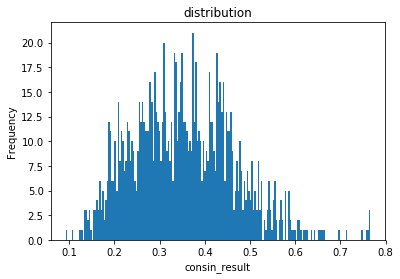

In [13]:
from matplotlib import pyplot
pyplot.hist(np.array(list_consin_result), 200)
pyplot.xlabel('consin_result')
pyplot.ylabel('Frequency')
pyplot.title('distribution')
pyplot.show()


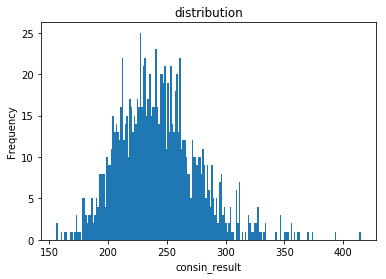

In [12]:
pyplot.hist(np.array(list_u_dis), 200)
pyplot.xlabel('consin_result')
pyplot.ylabel('Frequency')
pyplot.title('distribution')
pyplot.show()